<a href="https://colab.research.google.com/github/RoshaniPawar16/AAI/blob/main/Task1/Deep_Q_Learning_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function

> Indented block


$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



### Double Deep Q-Learning

We will implement Double Deep Q-Learning here. Double Deep Q-Learning is used to reduce the maximaztion bias in Q-Learning. This entails using two separate $Q$-value estimators, each of which is used to update the other. The target values are calculated using a target Q-network. The target Q-network's parameters are updated to the current networks every $C$ time steps.

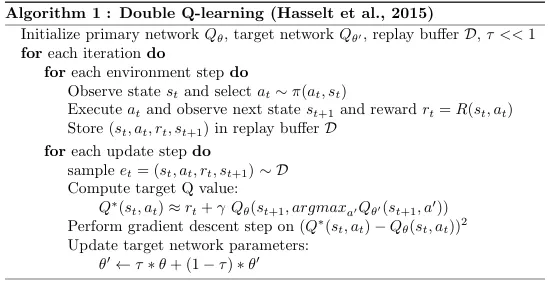

[Image Source](https://towardsdatascience.com/double-deep-q-networks-905dd8325412)

In [ ]:
!pip install gym --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827621 sha256=f98e21ee1c9337d1a0f39bfc88cbc429cbf595d1aad3c6b80f4b0e2133bba82d
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import time
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm import tqdm

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]], dtype=uint8)
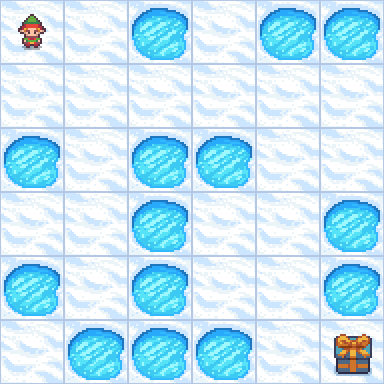

In [ ]:
# Create the environment
random_map = generate_random_map(size=6, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map,render_mode="rgb_array", is_slippery=True)
env.reset()
env.render()

In [ ]:
# Named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
nspace = env.observation_space.n
naction = env.action_space.n
print(nspace)

36


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, action_dim)
        )

        # Initialize weights using Xavier/Glorot initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

# class DQN(nn.Module):
#     def __init__(self, input_shape, out_actions):
#         super().__init__()

#         # https://poloclub.github.io/cnn-explainer/
#         self.conv_block1 = nn.Sequential(
#             nn.Conv2d(in_channels=input_shape, out_channels=10, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.conv_block2 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.layer_stack = nn.Sequential(
#             nn.Flatten(), # flatten inputs into a single vector
#             # After flattening the matrix into a vector, pass it to the output layer. To determine the input shape, use the print() statement in forward()
#             nn.Linear(in_features=10*1*1, out_features=out_actions)
#         )

#     def forward(self, x):
#         # current x is (32,100)
#         x = x.unsqueeze(0)
#         x = x.unsqueeze(1)
#         x = self.conv_block1(x)
#         x = self.conv_block2(x)
#         # print(x.shape)  # Use this to determine input shape of the output layer.
#         x = self.layer_stack(x)
#         return x

In [ ]:
def get_action(state, epsilon):
  ## First we randomize a number
  exp_exp_tradeoff = random.uniform(0, 1)
  ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
  if exp_exp_tradeoff > epsilon:
    with torch.no_grad():
      action = policy_net(state).max(1)[1].view(1, 1)

  # Else doing a random choice --> exploration
  else:
    action = env.action_space.sample()
    action = torch.tensor([action], device=device).view(1, 1)
  return action
    #exploration

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 10000         # Total training episodes
max_steps = 1000              # Max steps per episode
learning_rate = 1e-3         # Learning rate
gamma = 0.9                   # Discounting rate
batch_size = 32              # Training Batch size
target_update = 5            # Target network update frequency
train_frequency = 1           # Train Q network every train_frquency episodes
train_epochs = 2             # Training epochs during each training cycle

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.01/3          # Exponential decay rate for exploration prob

In [ ]:
policy_net = DQN(nspace, naction).to(device)
target_net = DQN(nspace, naction).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr = learning_rate)

# Initialize the replay buffer
memory = ReplayMemory(10000)

In [ ]:
def one_hot_encode(state, num_classes):
  one_hot_array = np.zeros(num_classes, dtype=np.float32)
  one_hot_array[state] = 1
  return one_hot_array

In [ ]:
def trainDQN(policy_net, target_net, optimizer, epsilon, total_episodes, memory):

  # List of rewards
  rewards = []
  for episode in tqdm(range(1, total_episodes+1)):
      # Initialize the environment and state
      state , prob = env.reset()
      state = one_hot_encode(state, nspace)
      state = torch.tensor([state], device=device)
      total_rewards = 0
      for _ in range(max_steps):
          # Select and perform an action
          action = get_action(state, epsilon)
          next_state, reward, done, _, _ = env.step(action.item())

          next_state = one_hot_encode(next_state, nspace)

          total_rewards += reward

          reward = torch.tensor([reward], device=device)
          done = torch.tensor([int(done)], device=device)
          next_state = torch.tensor([next_state], device=device)

          # Store the transition in memory
          memory.push(state, action, next_state, reward, done)

          # Move to the next state
          state = next_state

          if done:
              break

      # optimize the policy
      if episode % train_frequency == 0 and len(memory) >= batch_size:
        total_loss = 0
        for _ in range(train_epochs):
          # get samples from experience replay memory
          transitions = memory.sample(batch_size)
          # unroll and reroll to get them in proper format
          batch = Transition(*zip(*transitions))

          state_batch = torch.cat(batch.state)
          action_batch = torch.cat(batch.action)
          next_state_batch = torch.cat(batch.next_state)
          reward_batch = torch.cat(batch.reward)
          done_batch = torch.cat(batch.done)

          # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
          # columns of actions taken
          state_action_values = policy_net(state_batch).gather(1, action_batch)

          # Compute V(s_{t+1}) for all next states and get the max q values.
          with torch.no_grad():
            next_state_values = target_net(next_state_batch).max(1)[0].detach()
          # Compute the target Q values
          target_q_values = (next_state_values * (1-done_batch) * gamma) + reward_batch

          # Compute Huber loss
          loss = F.smooth_l1_loss(state_action_values, target_q_values.unsqueeze(1))

          # Optimize the model
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


      # Update the target network
      if episode % target_update == 0:
          target_net.load_state_dict(policy_net.state_dict())

      # Reduce epsilon (because we need less and less exploration)
      epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
      rewards.append(total_rewards)
      if episode % 1000 == 0:
        print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")
      # print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")

  print ("Score over time: " +  str(sum(rewards)/total_episodes))
  return rewards

In [ ]:
rewards = trainDQN(policy_net, target_net, optimizer, epsilon, total_episodes, memory)

 10%|█         | 1012/10000 [00:08<01:55, 77.71it/s]

Episode 1000: Reward = 0.0, Epsilon = 0.04531725341377987


 20%|██        | 2015/10000 [00:17<01:09, 115.72it/s]

Episode 2000: Reward = 0.0, Epsilon = 0.01125990746332641


 30%|███       | 3026/10000 [00:27<00:56, 123.22it/s]

Episode 3000: Reward = 0.0, Epsilon = 0.010044945930464861


 40%|████      | 4023/10000 [00:36<00:47, 126.62it/s]

Episode 4000: Reward = 0.0, Epsilon = 0.010001603400824389


 50%|█████     | 5015/10000 [00:44<00:53, 93.50it/s]

Episode 5000: Reward = 0.0, Epsilon = 0.010000057199710342


 60%|██████    | 6023/10000 [00:53<00:33, 117.92it/s]

Episode 6000: Reward = 0.0, Epsilon = 0.010000002040542086


 70%|███████   | 7022/10000 [01:03<00:27, 109.02it/s]

Episode 7000: Reward = 0.0, Epsilon = 0.010000000072794285


 80%|████████  | 8018/10000 [01:11<00:17, 112.44it/s]

Episode 8000: Reward = 0.0, Epsilon = 0.010000000002596864


 90%|█████████ | 9021/10000 [01:20<00:08, 114.41it/s]

Episode 9000: Reward = 0.0, Epsilon = 0.010000000000092641


100%|██████████| 10000/10000 [01:30<00:00, 111.10it/s]

Episode 10000: Reward = 0.0, Epsilon = 0.010000000000003305
Score over time: 0.0002


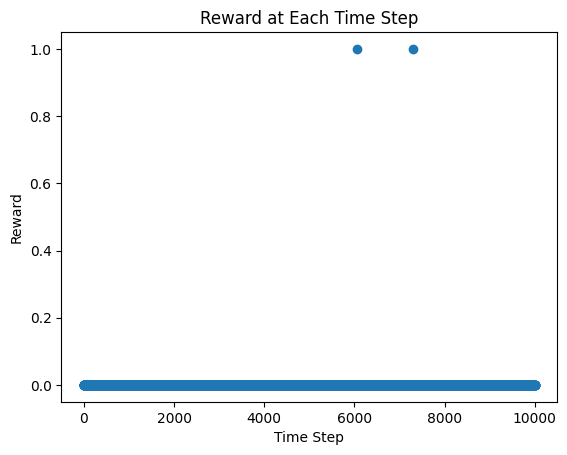

In [ ]:
plt.plot(rewards, 'o')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.title('Reward at Each Time Step')
plt.show()

Really good results! Accuracy of 43%

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, prob = env.reset()
    state = one_hot_encode(state, nspace)
    state = torch.tensor([state], device=device)
    done = False
    epsilon = 0
    tl = 0
    max_steps = 500000
    for t in range(max_steps):
        vid.capture_frame()
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)
        next_state, reward, done, info, _ = env.step(action.item())
        next_state = one_hot_encode(next_state, nspace)
        tl+=reward
        next_state = torch.tensor([next_state], device=device)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()
    print(tl)

In [ ]:
show_video_of_model("FrozenLake-v1")

Moviepy - Building video video/FrozenLake-v1.mp4.
Moviepy - Writing video video/FrozenLake-v1.mp4



Moviepy - Done !
Moviepy - video ready video/FrozenLake-v1.mp4
0.0


In [ ]:
show_video("FrozenLake-v1")

In [ ]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from tqdm import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(50)

# Create the environment with is_slippery=True
random_map = generate_random_map(size=5, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array", is_slippery=True)
env.reset()
env.render()

# Named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

nspace = env.observation_space.n
naction = env.action_space.n
print(nspace)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, action_dim)
        )

        # Initialize weights using Xavier/Glorot initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

def get_action(state, epsilon):
    exp_exp_tradeoff = random.uniform(0, 1)
    if exp_exp_tradeoff > epsilon:
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)
    else:
        # action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        action = env.action_space.sample()
        action = torch.tensor(np.array(action), device=device).view(1, 1)
    return action

# Hyperparameters
total_episodes = 2500
max_steps = 500
learning_rate = 5e-4
gamma = 0.9
batch_size = 64
target_update = 5
train_frequency = 1
train_epochs = 15

# Exploration parameters
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.1
decay_rate = 0.001

policy_net = DQN(nspace, naction).to(device)
target_net = DQN(nspace, naction).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Initialize the replay buffer
memory = ReplayMemory(10000)

def one_hot_encode(state, num_classes):
    one_hot_array = np.zeros(num_classes, dtype=np.float32)
    one_hot_array[state] = 1
    return one_hot_array

def trainDQN(policy_net, target_net, optimizer, epsilon, total_episodes, memory):
    rewards = []
    for episode in tqdm(range(1, total_episodes + 1)):
        current_state, _ = env.reset()
        state = one_hot_encode(current_state, nspace)
        # state = torch.tensor([state], device=device)
        state = torch.tensor(np.array([state]), device=device)
        total_rewards = 0
        for _ in range(max_steps):
            action = get_action(state, epsilon)
            next_state, org_reward, done, _, _ = env.step(action.item())

            # Modify the reward structure to guide the agent more effectively
            # if done:
            #     if org_reward == 1:
            #         reward = 10  # Large reward for reaching the goal to reinforce success
            #     else:
            #         reward = -10  # Significant penalty for falling into a hole or failure
            # else:
            #     if org_reward == 0 and next_state != current_state :
            #         reward = 0.1 * next_state/100
            #     else:
            #         reward = -0.1 * next_state/100

            if done:
                if org_reward == 1:
                    reward = 10  # Large reward for successfully reaching the goal
                else:
                    reward = -10  # Significant penalty for failing (e.g., falling into a hole)
            else:
                # Reward for making progress (encourage exploration)
                if next_state != current_state:
                    # Use a scaled positive reward for making any move
                    reward = 0.1  # Base reward for taking a valid step
                    goal_position = 99

                    # Additional reward for moving closer to the goal
                    current_distance = np.linalg.norm(np.array(current_state) - np.array(goal_position))
                    next_distance = np.linalg.norm(np.array(next_state) - np.array(goal_position))

                    if next_distance < current_distance:
                        reward += 0.5  # Bonus for moving closer to the goal
                    else:
                        reward -= 0.05  # Small penalty for not making progress
                else:
                    # Small penalty for remaining in the same state (if applicable)
                    reward = -0.1  # Penalize no movement or regressive steps


            next_state = one_hot_encode(next_state, nspace)
            total_rewards += org_reward

            reward = torch.tensor(np.array([reward]), device=device)
            done = torch.tensor(np.array([int(done)]), device=device)
            next_state = torch.tensor(np.array([next_state]), device=device)

            memory.push(state, action, next_state, reward, done)
            state = next_state

            if done:
                break

        if episode % train_frequency == 0 and len(memory) >= batch_size:
            for _ in range(train_epochs):
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))

                state_batch = torch.cat(batch.state)
                action_batch = torch.cat(batch.action)
                next_state_batch = torch.cat(batch.next_state)
                reward_batch = torch.cat(batch.reward)
                done_batch = torch.cat(batch.done)

                state_action_values = policy_net(state_batch).gather(1, action_batch)

                with torch.no_grad():
                    next_state_values = target_net(next_state_batch).max(1)[0].detach()

                target_q_values = (next_state_values * (1 - done_batch) * gamma) + reward_batch

                loss = F.smooth_l1_loss(state_action_values, target_q_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        epsilon = max(min_epsilon, epsilon * (1 - decay_rate))
        rewards.append(total_rewards)
        if episode % 1000 == 0:
            print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")

    print("Score over time: " + str(sum(rewards) / total_episodes))
    return rewards

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, prob = env.reset()
    state = one_hot_encode(state, nspace)
    state = torch.tensor(np.array([state]), device=device)
    done = False
    epsilon = 0
    tl = 0
    max_steps = 500000
    for t in range(max_steps):
        vid.capture_frame()
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)
        next_state, reward, done, info, _ = env.step(action.item())
        next_state = one_hot_encode(next_state, nspace)
        tl+=reward
        next_state = torch.tensor(np.array([next_state]), device=device)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        # break in the next iteration
        if done:
            break

    vid.close()
    env.close()
    print(tl)

rewards = trainDQN(policy_net, target_net, optimizer, epsilon, total_episodes, memory)

def moving_average(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')


sns.lineplot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward at Each Episode')
plt.show()

#create line plot using moving average
window_size = 10
rewards_ma = moving_average(rewards, window_size)
sns.lineplot(rewards_ma)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward at Each Episode')
plt.show()


show_video_of_model("FrozenLake-v1")

show_video("FrozenLake-v1")


25


 37%|███▋      | 925/2500 [01:07<01:43, 15.15it/s]